# LSTM based Seq2Seq model

### Importing the libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np

## Data Preprocessing

### Loading the dataset

In [21]:
dataset = load_dataset("cnn_dailymail", "3.0.0", split='train[:10%]')

In [22]:
print(dataset)

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 28711
})


### Preprocessing the text data

In [23]:
# Extract input and output texts
input_texts = [item['article'] for item in dataset]
output_texts = ['<start> ' + item['highlights'] + ' <end> ' for item in dataset]  # Add <start> and <end> tokens to the output

print(input_texts[3])
print(output_texts[0:5])

WASHINGTON (CNN) -- Doctors removed five small polyps from President Bush's colon on Saturday, and "none appeared worrisome," a White House spokesman said. The polyps were removed and sent to the National Naval Medical Center in Bethesda, Maryland, for routine microscopic examination, spokesman Scott Stanzel said. Results are expected in two to three days. All were small, less than a centimeter [half an inch] in diameter, he said. Bush is in good humor, Stanzel said, and will resume his activities at Camp David. During the procedure Vice President Dick Cheney assumed presidential power. Bush reclaimed presidential power at 9:21 a.m. after about two hours. Doctors used "monitored anesthesia care," Stanzel said, so the president was asleep, but not as deeply unconscious as with a true general anesthetic. He spoke to first lady Laura Bush -- who is in Midland, Texas, celebrating her mother's birthday -- before and after the procedure, Stanzel said. Afterward, the president played with his

In [ ]:
# Define maximum sequence lengths
max_input_length = 750  # maximum length for articles
max_output_length = 50  # maximum length for summaries
max_features = 100000  # Max number of words

# Create tokenizers and word_index that maps words to unique integers based on word frequency
input_tokenizer = Tokenizer(filters='', oov_token="<OOV>")
input_tokenizer.fit_on_texts(input_texts)

output_tokenizer = Tokenizer(filters='', oov_token="<OOV>")

output_tokenizer.fit_on_texts(output_texts)

# Convert texts to sequences of integers
input_sequences = input_tokenizer.texts_to_sequences(input_texts)
output_sequences = output_tokenizer.texts_to_sequences(output_texts)

# Pad the sequences
encoder_input_data = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
decoder_input_data = pad_sequences(output_sequences, maxlen=max_output_length, padding='post')

In [25]:
print("input tokenizer first 10 words")
for key, value in list(input_tokenizer.word_index.items())[:10]:
    print(f"{key}: {value}")


print("output tokenizer first 10 words")
for key, value in list(output_tokenizer.word_index.items())[:10]:
    print(f"{key}: {value}")


input tokenizer first 10 words
<OOV>: 1
the: 2
to: 3
of: 4
a: 5
and: 6
in: 7
that: 8
for: 9
is: 10
output tokenizer first 10 words
<OOV>: 1
the: 2
to: 3
in: 4
<start>: 5
<end>: 6
of: 7
.: 8
a: 9
and: 10


In [27]:
# During training, decoder receives decoder_input as well as decoder_output i.e. correct next token it should predict at each step (a.k.a. teacher forcing strategy)
# Prepare the decoder output data (by shifting token by 1) 
decoder_output_data = np.zeros_like(decoder_input_data)
decoder_output_data[:, :-1] = decoder_input_data[:, 1:]

In [28]:
# Total vocab size includes all the words and a padding token
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

## Building the Seq2Seq model using LSTMs

### Defining an encoder

In [29]:
# Defining an encoder with chained layer calls to specify model's forward pass

# Define input layer
encoder_inputs =  tf.keras.layers.Input(shape=(max_input_length,))

# Embedding layer to represent words as dense vectors
encoder_embedding = tf.keras.layers.Embedding(input_dim=input_vocab_size, output_dim=128, input_length=max_input_length)(encoder_inputs)

# return_state=True is needed to generate encoder_outputs and hidden states (acts as context vector) which needs to be passed to decoder
encoder_lstm = tf.keras.layers.LSTM(64, return_state=True, return_sequences=False) 
  
# Fetch encoder states, where state_h (hidden state) captures short term memory & state_c (cell state) captures long term memory of the sequence
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding) 
encoder_states = [state_h, state_c]  # These are used as initial states for the decoder

### Defining a decoder

In [30]:
# Defining a decoder with chained layer calls to specify model's forward pass

# Define decoder input
decoder_inputs =  tf.keras.layers.Input(shape=(max_output_length,))

# Embedding layer to represent words as dense vectors
decoder_embedding = tf.keras.layers.Embedding(input_dim=output_vocab_size, output_dim=128, input_length=max_output_length)(decoder_inputs)

# return_sequences=True is needed as decoder needs to generate an output/word for each time step in the output sequence instead of just final hidden state
decoder_lstm =  tf.keras.layers.LSTM(64, return_sequences=True, return_state=True)

# Get the decoder's output and states
# decoder_outputs will be used for generating the next predicted tokens
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

#### Output layer of decoder

In [31]:
# Final dense layer to output probabilities for the next word in the sequence
decoder_dense = tf.keras.layers.Dense(output_vocab_size, activation='softmax')

decoder_final_output = decoder_dense(decoder_outputs)

### Creating a model

In [32]:
# Creating a model from inputs and outputs using Functional API 
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_final_output, name='text_summarization_model')
print(model.summary())

Model: "text_summarization_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 750)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 750, 128)  │ 49,269,632 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 50, 128)   │ 11,616,256 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 64),      │     49,408 │ embedding_2[0][0] │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 50, 64),  │     49,408 │ embedding_3[0][0… │
│                     │ (None, 64),       │            │ lstm_2[0][1],     │
│                     │ (None, 64)]       │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50, 90752) │  5,898,880 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 66,883,584 (255.14 MB)

 Trainable params: 66,883,584 (255.14 MB)

 Non-trainable params: 0 (0.00 B)

None


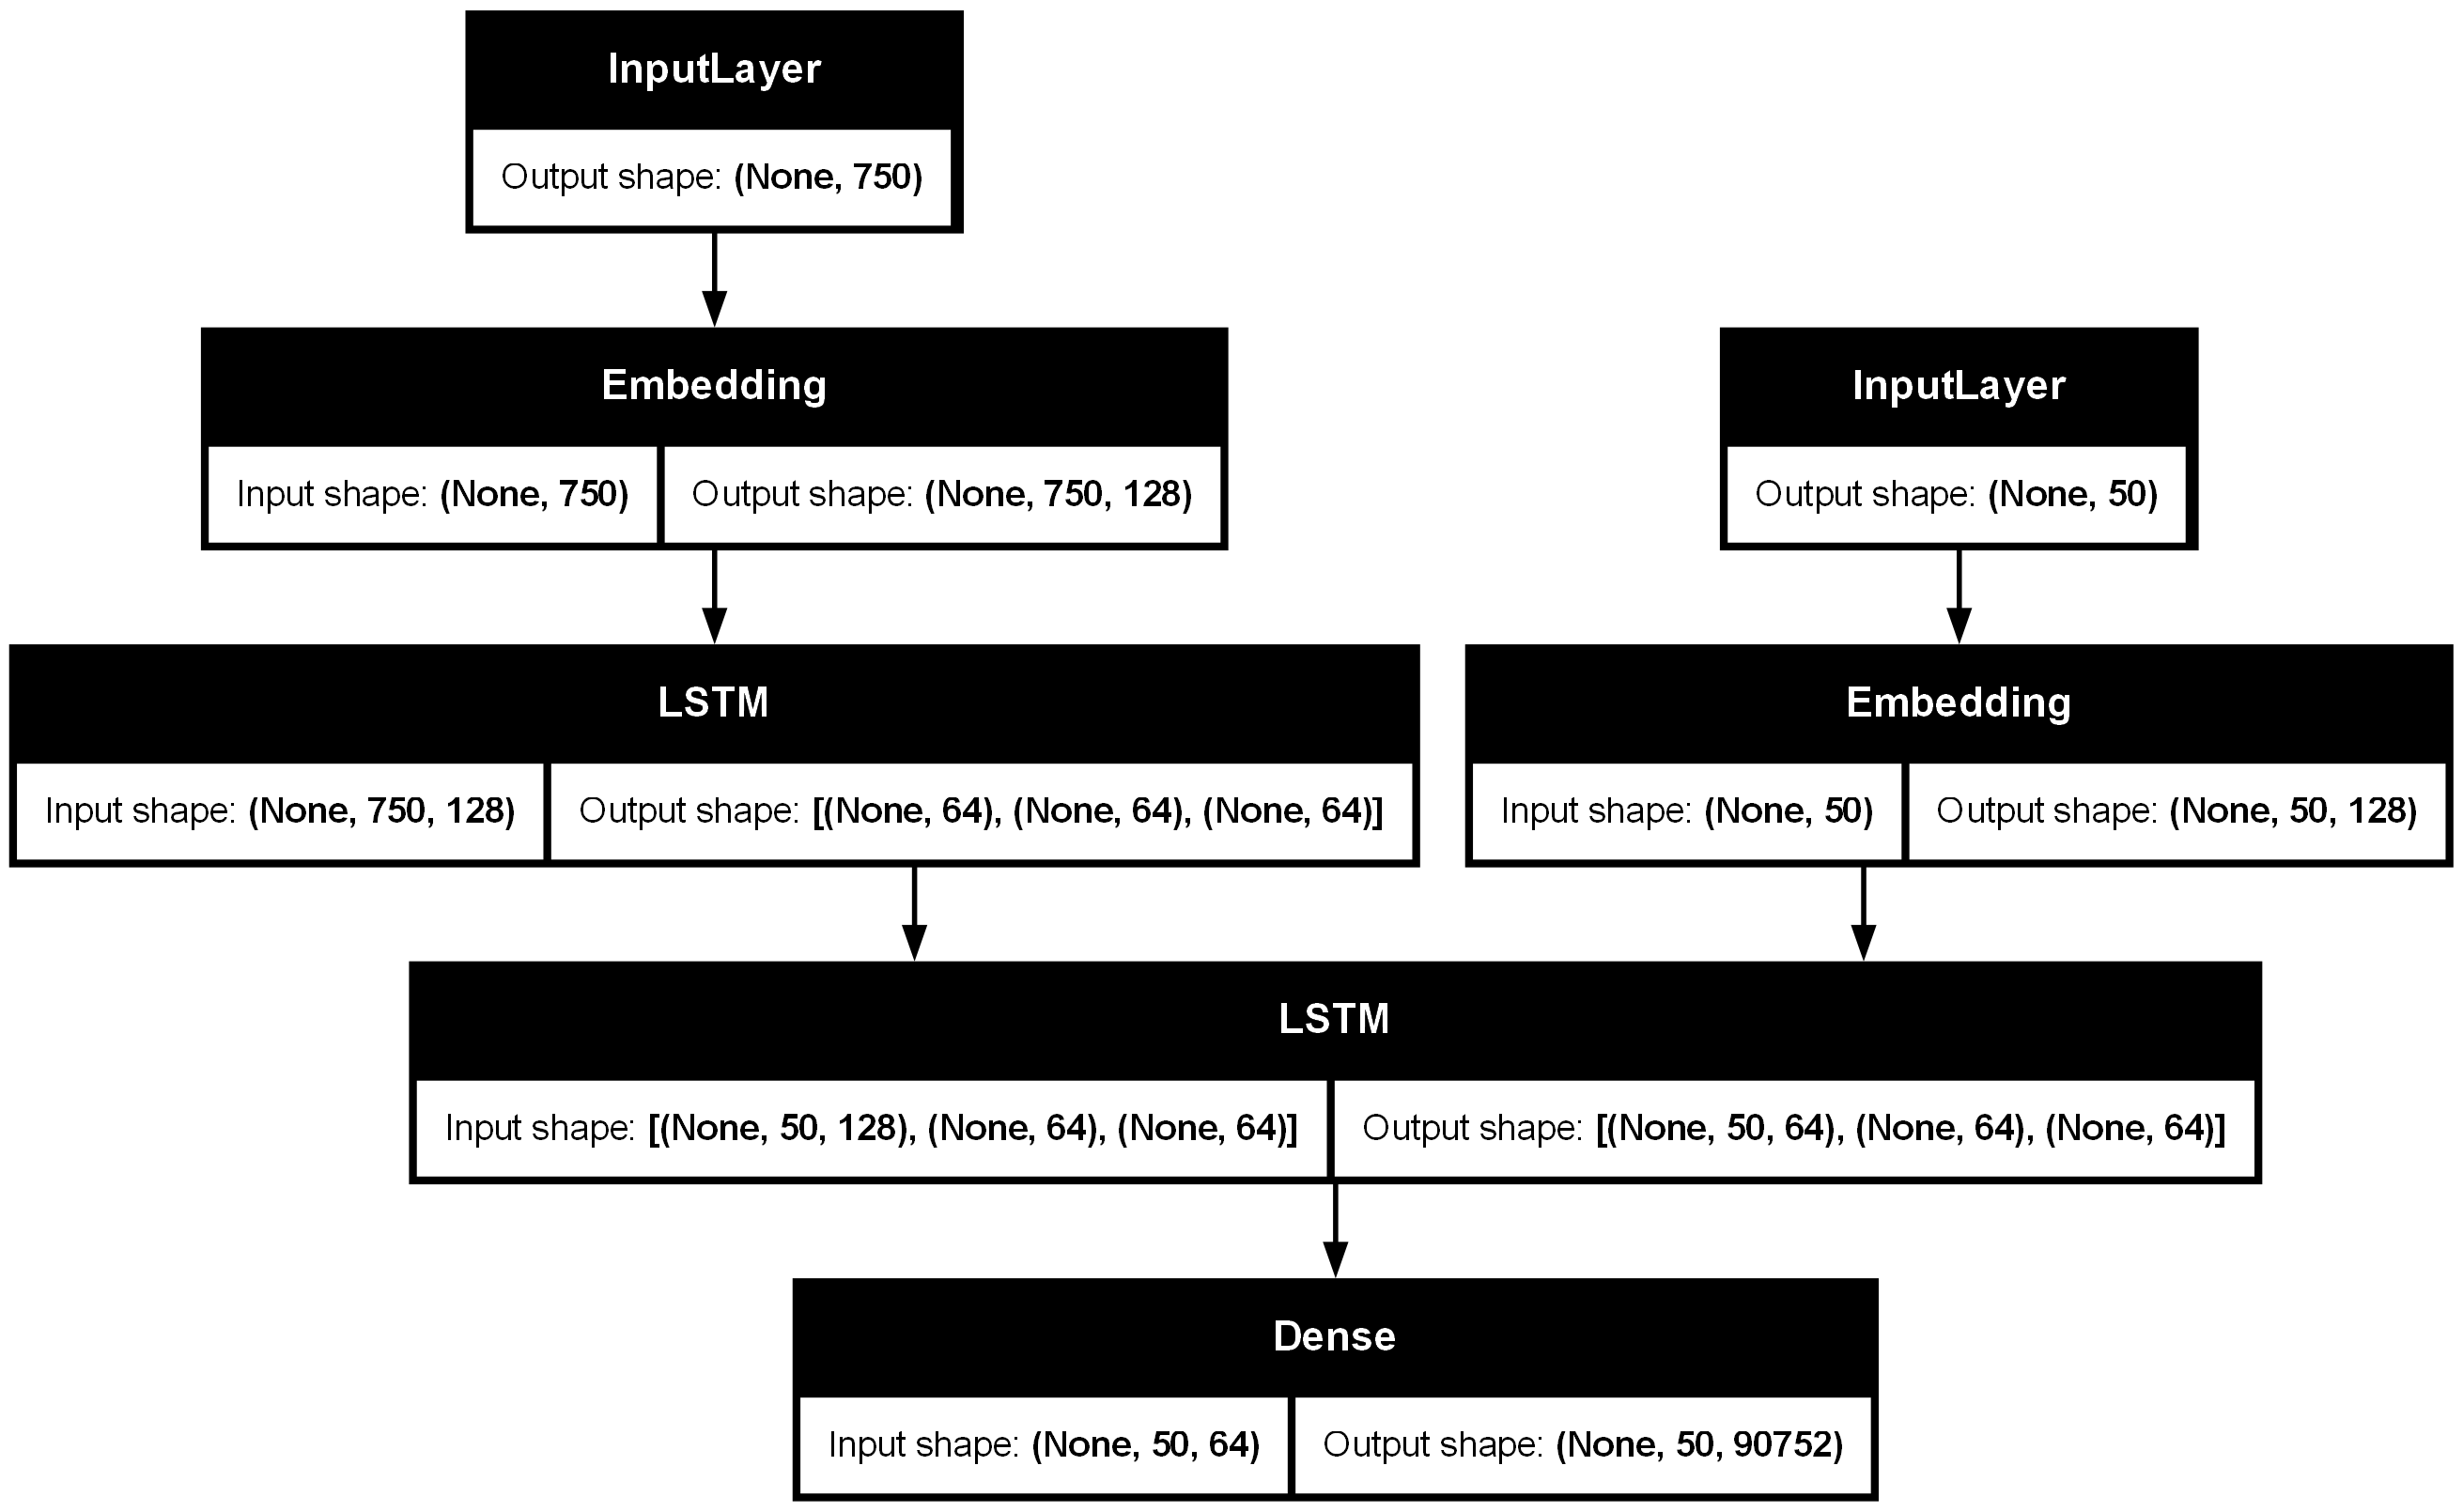

In [ ]:
# plotting the model
tf.keras.utils.plot_model(model, "models/seq2seq/seq2seq_text_summarization_model.png", show_shapes=True)

## Training the model


### Compiling the model

In [34]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Training the model and evaluating it on the validation set 

In [35]:
# Train the model
history = model.fit(
    [encoder_input_data, decoder_input_data], 
    np.expand_dims(decoder_output_data, -1),  # Decoder output must have shape (batch_size, timesteps, 1)
    batch_size=16,
    epochs=5,
    validation_split=0.2  # Use 20% of the data for validation
)



Epoch 1/5
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 1887s 1s/step - accuracy: 0.1905 - loss: 7.5358 - val_accuracy: 0.2254 - val_loss: 6.6502
Epoch 2/5
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 2307s 2s/step - accuracy: 0.2497 - loss: 6.3206 - val_accuracy: 0.2541 - val_loss: 6.3644
Epoch 3/5
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 1816s 1s/step - accuracy: 0.2795 - loss: 5.9035 - val_accuracy: 0.2667 - val_loss: 6.1833
Epoch 4/5
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 1801s 1s/step - accuracy: 0.2989 - loss: 5.5505 - val_accuracy: 0.2740 - val_loss: 6.0919
Epoch 5/5
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 3003s 2s/step - accuracy: 0.3110 - loss: 5.3029 - val_accuracy: 0.2788 - val_loss: 6.0481


## Visualize the model performance

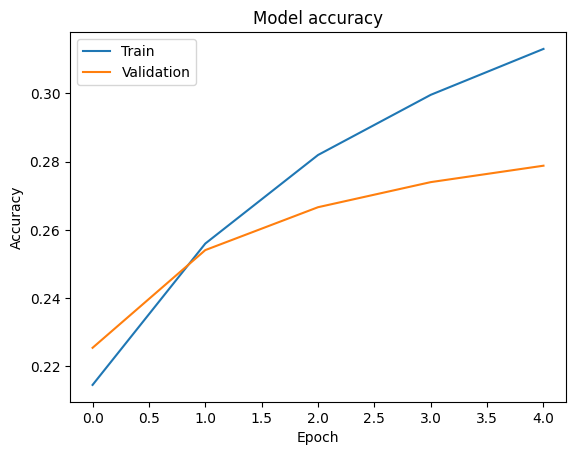

In [36]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



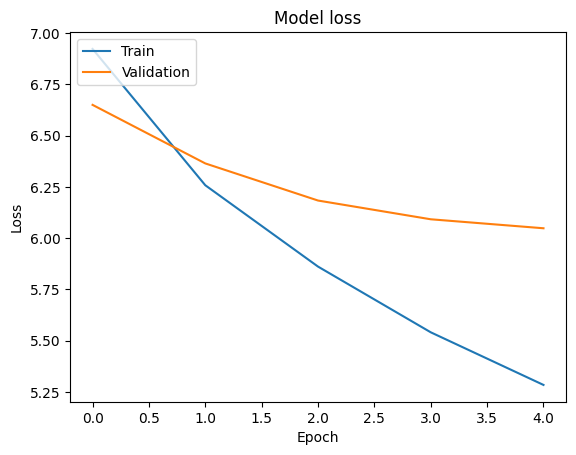

In [37]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Making a single prediction

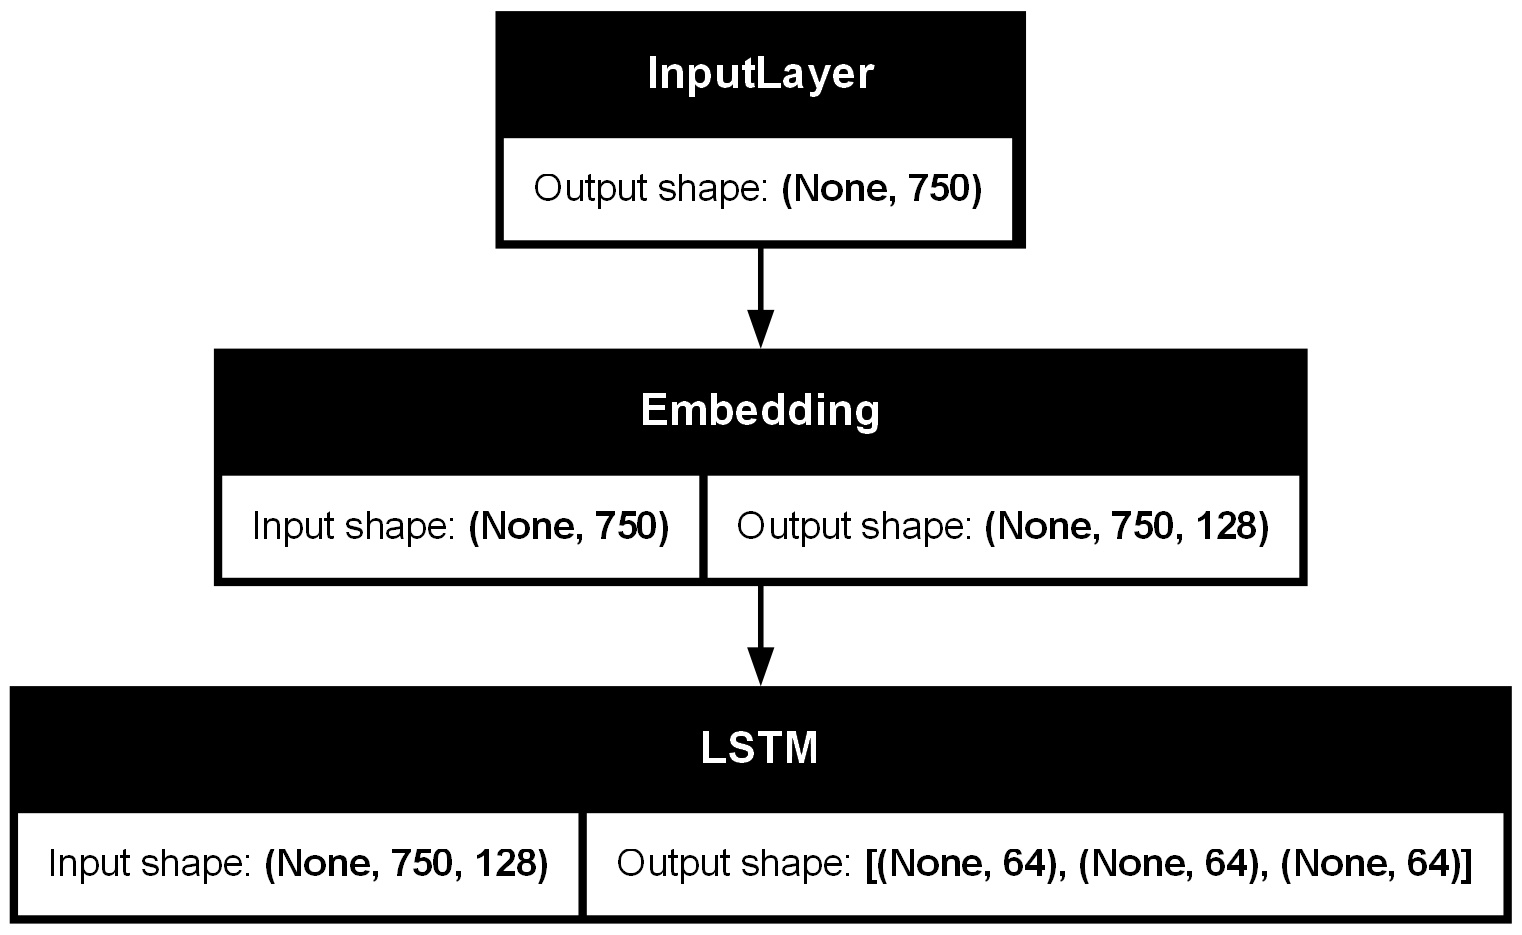

In [ ]:
# Encoder Model
encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)

# plotting the model
tf.keras.utils.plot_model(encoder_model, "models/seq2seq/encoder_inference_model.png", show_shapes=True)

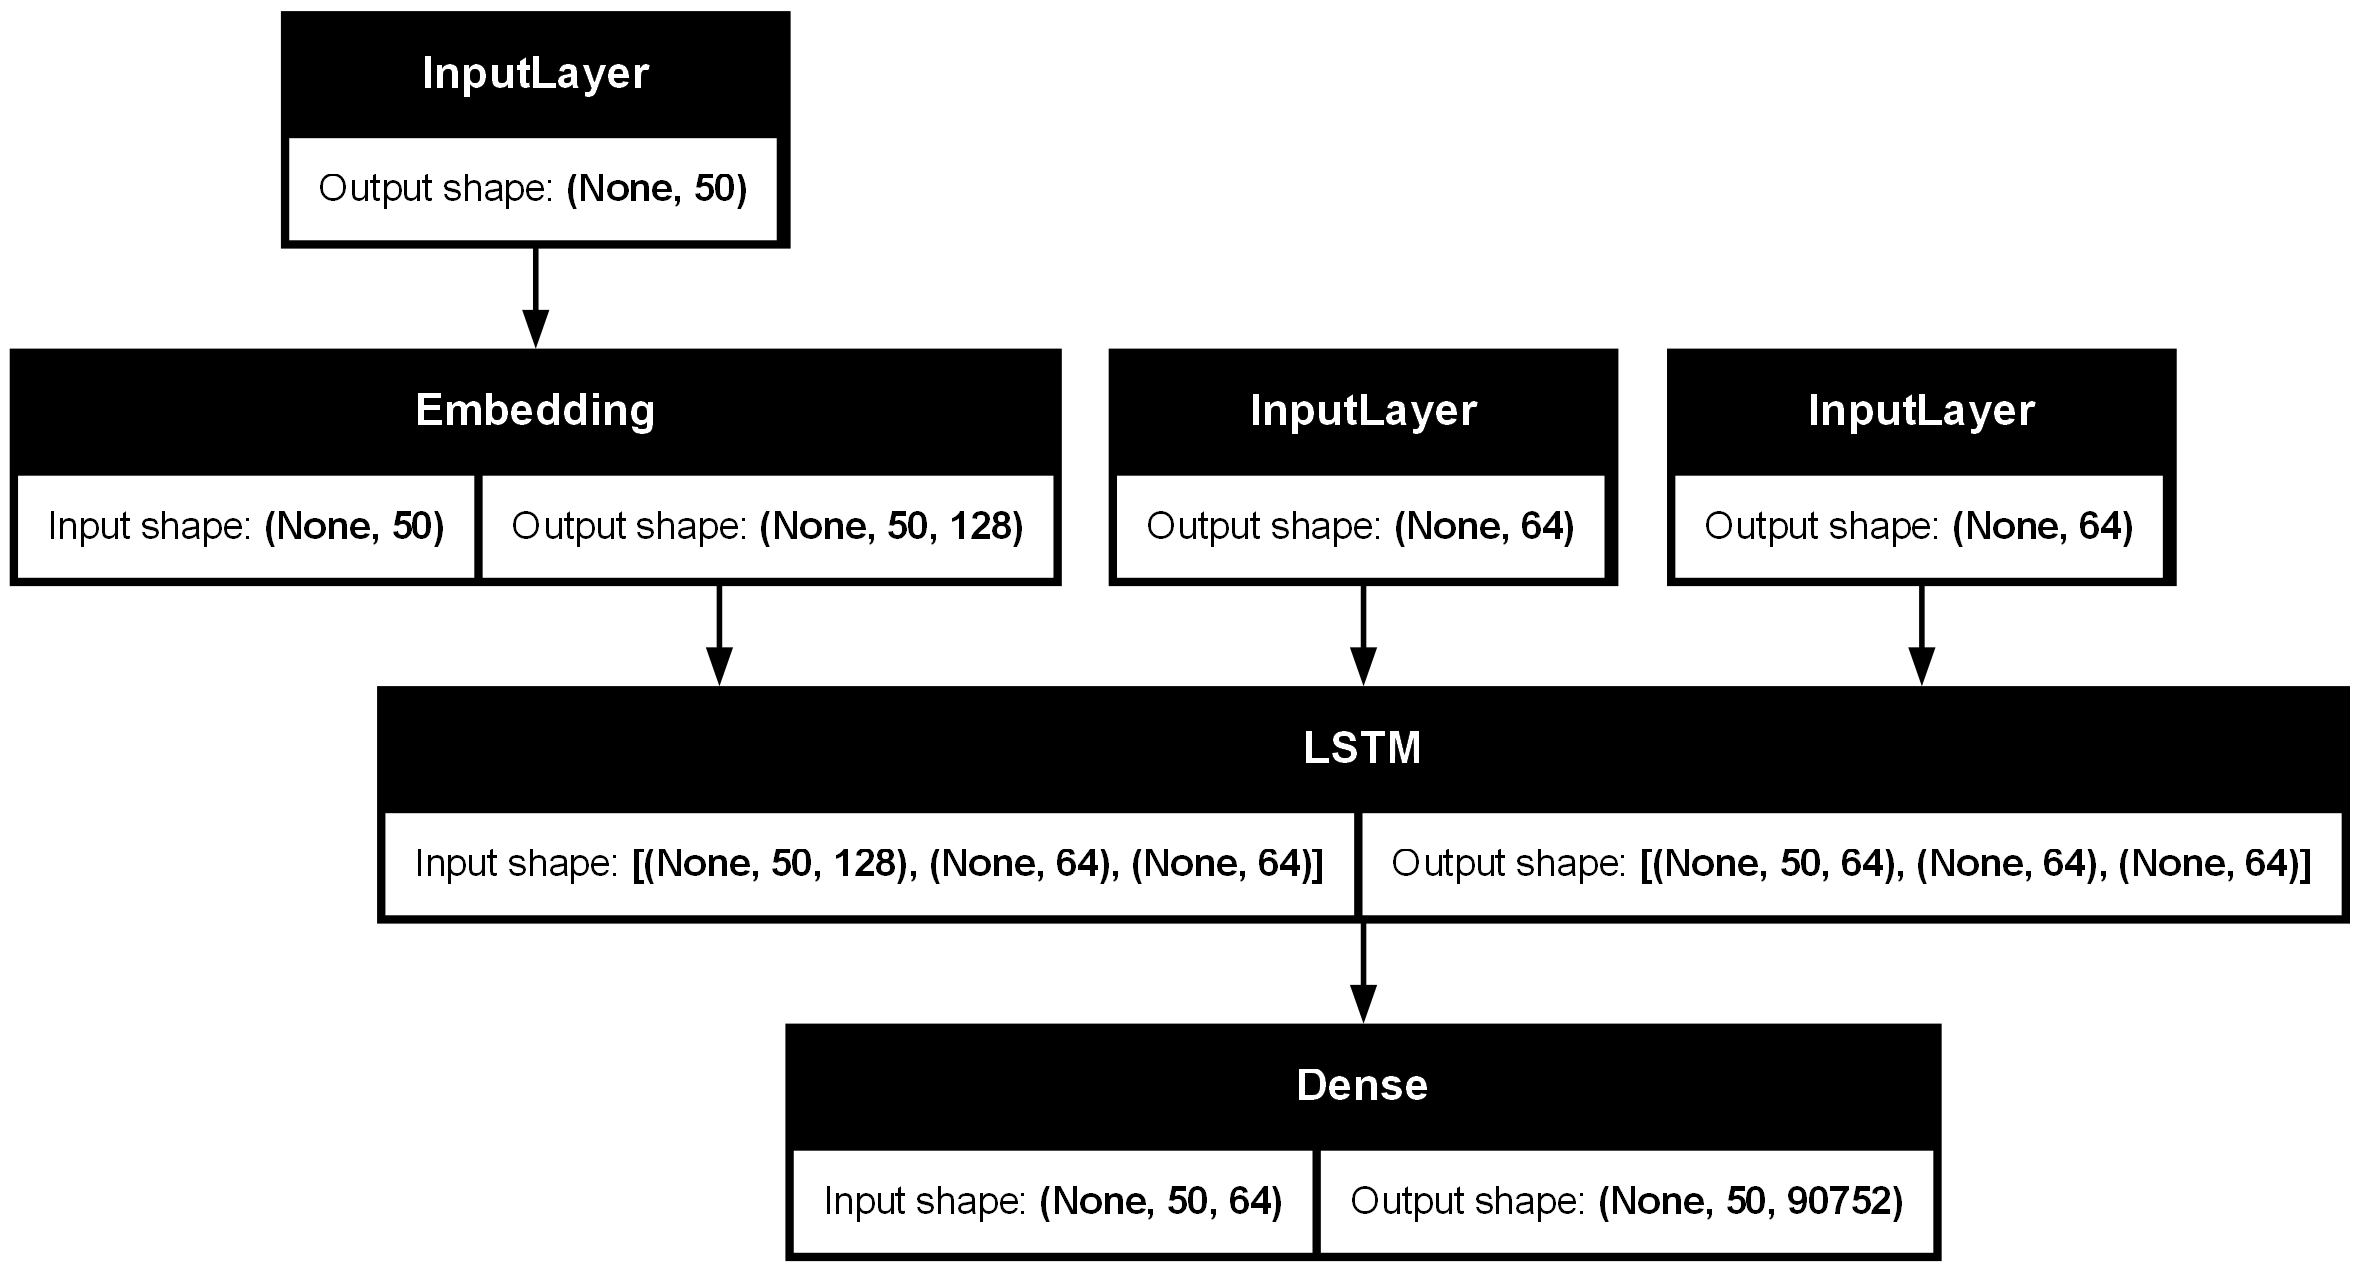

In [ ]:
# Decoder state inputs (for feeding back at each timestep)
decoder_state_input_h = tf.keras.layers.Input(shape=(64,))
decoder_state_input_c = tf.keras.layers.Input(shape=(64,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Decoder embeddings
decoder_embedding_layer = tf.keras.layers.Embedding(output_vocab_size, 128)
decoder_embedded_inputs = decoder_embedding_layer(decoder_inputs)

# Decoder LSTM (for inference)
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedded_inputs, initial_state=decoder_states_inputs
)

decoder_states = [state_h, state_c]

# Dense layer to predict next word
decoder_dense = tf.keras.layers.Dense(output_vocab_size, activation="softmax")
decoder_final_output = decoder_dense(decoder_outputs)

# Define inference model
decoder_model = tf.keras.models.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_final_output] + decoder_states
)

# plotting the model
tf.keras.utils.plot_model(decoder_model, "models/seq2seq/decoder_inference_model.png", show_shapes=True)



In [47]:
def summarize_text(input_text):
    """
    Generate summary using trained Seq2Seq model.
    """
    # Tokenize and pad the input text
    input_seq = input_tokenizer.texts_to_sequences([input_text])
    input_padded = pad_sequences(input_seq, maxlen=max_input_length, padding='post')

    # Get the encoder's output states
    states_value = encoder_model.predict(input_padded)

    # Start decoding with the "<start>" token
    target_seq = np.zeros((1, 1))
  
   
    target_seq[0, 0] = output_tokenizer.word_index['<start>']
   

    output_text = []

    for _ in range(max_output_length):
        # Predict the next word
        output_probs, h, c = decoder_model.predict([target_seq] + states_value)

        # Get the highest probability word
        predicted_id = np.argmax(output_probs[0, -1, :])

        if predicted_id == 0:
            break  # Stop if unknown word

        word = output_tokenizer.index_word.get(predicted_id, "<OOV>")
        output_text.append(word)

        if word == "<end>":
            break  # Stop decoding

        # Update the target sequence for the next timestep
        target_seq[0, 0] = predicted_id
        states_value = [h, c]  # Update states

    return ' '.join(output_text).replace("\n", "")


new_text = "When Delta Flight 4819 from Minneapolis to Toronto landed in a fiery crash that ripped off a wing and rolled the plane upside down, panicked onlookers feared the worst. But Michael McCormick saw decades of aircraft safety improvements in action. All 80 people on board survived Monday’s crash at Toronto Pearson International Airport. “That was absolutely phenomenal that you could see an aircraft on its back like that and have people walking away from it,” said McCormick, an associate professor at Embry-Riddle Aeronautical University."
summary = summarize_text(new_text)
print("Generated Summary:", summary)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━